# Decision Tree Regression

Fitting 1 folds for each of 20 candidates, totalling 20 fits
Best parameters for Decision Tree: {'min_samples_split': 1000, 'min_samples_leaf': 100, 'max_depth': 100}


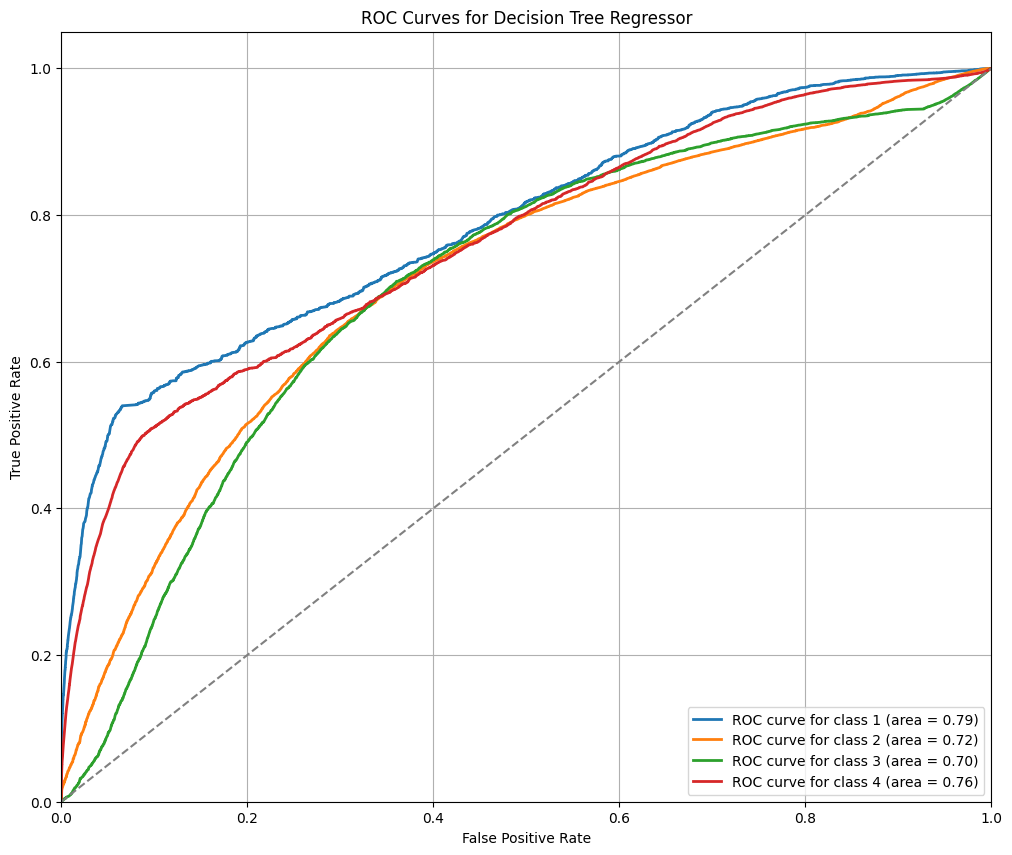

Decision Tree Regression - MAE: 0.3674253150058317
Decision Tree Regression - MSE: 0.40169423470358634
Test Accuracy: 0.6496
R-squared (R²): -0.7175
Classification Report:
              precision    recall  f1-score   support

           1       0.21      0.22      0.21      9362
           2       0.89      0.67      0.76    873568
           3       0.30      0.67      0.41    188164
           4       0.30      0.18      0.22     27219

    accuracy                           0.65   1098313
   macro avg       0.42      0.43      0.40   1098313
weighted avg       0.77      0.65      0.68   1098313



In [1]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, accuracy_score, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.model_selection import RandomizedSearchCV, PredefinedSplit
from sklearn.preprocessing import label_binarize
from scipy.special import softmax

train_data = pd.read_csv("Train_Set.csv")
val_data = pd.read_csv("Validation_Set.csv")
test_data = pd.read_csv('Test_Set.csv')

X = train_data.drop(columns=["Severity"])
y = train_data["Severity"]

X_test = test_data.drop(columns=["Severity"])
y_test = test_data["Severity"]

combined_data = pd.concat([train_data, val_data], axis=0)
X_combined = combined_data.drop(columns=["Severity"])
y_combined = combined_data["Severity"]

# Create an indicator array for the validation set split
split_index = [-1] * len(train_data) + [0] * len(val_data)
predefined_split = PredefinedSplit(test_fold=split_index)

# Parameter grid for DecisionTreeRegressor
model_dt_param = {
    'min_samples_leaf': [10, 100, 200, 500],
    'min_samples_split': [10, 100, 1000],
    'max_depth': [10, 100, 200, 500]
}

# Initialize RandomizedSearchCV with DecisionTreeRegressor
model_dt_cv = RandomizedSearchCV(
    DecisionTreeRegressor(random_state=42),
    param_distributions=model_dt_param,
    cv=predefined_split,
    n_iter=20,
    n_jobs=-1,
    scoring='neg_mean_squared_error',
    verbose=2
)

model_dt_cv.fit(X_combined, y_combined)

# Get the best model from hyperparameter tuning
best_dt_model = model_dt_cv.best_estimator_
print("Best parameters for Decision Tree:", model_dt_cv.best_params_)

# Make predictions using the best model
y_pred_dt = best_dt_model.predict(X_test)
y_pred_dt_rounded = y_pred_dt.round().astype(int)  

classes = sorted(y_test.unique())
n_classes = len(classes)

# Compute distances from each prediction to each class
distance_matrix = np.abs(y_pred_dt[:, np.newaxis] - np.array(classes))

# Convert distances to pseudo-probabilities using softmax
# The lower the distance, the higher the "probability"
pseudo_prob_matrix = softmax(-distance_matrix, axis=1)

# Binarize the true labels for ROC curve
y_test_binarized = label_binarize(y_test, classes=classes)

# Plot ROC curves for each class
plt.figure(figsize=(12, 10))

for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_binarized[:, i], pseudo_prob_matrix[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'ROC curve for class {classes[i]} (area = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Decision Tree Regressor')
plt.legend(loc="lower right")
plt.grid()
plt.show()


# Evaluation Metrics
mae_dt = mean_absolute_error(y_test, y_pred_dt_rounded)
mse_dt = mean_squared_error(y_test, y_pred_dt_rounded)
r2 = r2_score(y_test, y_pred_dt_rounded)
accuracy = accuracy_score(y_test, y_pred_dt_rounded)
classification_report_str = classification_report(y_test, y_pred_dt_rounded)

# Output the results
print(f"Decision Tree Regression - MAE: {mae_dt}")
print(f"Decision Tree Regression - MSE: {mse_dt}")
print(f"Test Accuracy: {accuracy:.4f}")
print(f"R-squared (R²): {r2:.4f}")
print("Classification Report:")
print(classification_report_str)
